In [41]:
import os
from pathlib import Path
CANDIDATE_NAME = 'SADANALA_ASHRITHA'

ROOT = Path(f"/content/ds_{CANDIDATE_NAME}")
CSV_DIR = ROOT / "csv_files"
OUTPUTS_DIR = ROOT / "outputs"

for p in [ROOT, CSV_DIR, OUTPUTS_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print('Project folders created:')
print(ROOT)
print(CSV_DIR)
print(OUTPUTS_DIR)


Project folders created:
/content/ds_SADANALA_ASHRITHA
/content/ds_SADANALA_ASHRITHA/csv_files
/content/ds_SADANALA_ASHRITHA/outputs


In [42]:
!pip install -q gdown fpdf pandas matplotlib seaborn scipy
!pip install fpdf

print('If running on Colab, run the pip install line above once.')


If running on Colab, run the pip install line above once.


In [43]:
TRADER_FILE_ID = '1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs'
SENTIMENT_FILE_ID = '1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf'

trader_out = CSV_DIR / 'hyperliquid_trader_data.csv'
sentiment_out = CSV_DIR / 'fear_greed.csv'
import gdown
try:
    if not trader_out.exists():
        gdown.download(f'https://drive.google.com/uc?id={TRADER_FILE_ID}', str(trader_out), quiet=False)
    if not sentiment_out.exists():
        gdown.download(f'https://drive.google.com/uc?id={SENTIMENT_FILE_ID}', str(sentiment_out), quiet=False)
    print('Downloaded (or found) files at:')
    print(trader_out)
    print(sentiment_out)
except Exception as e:
    print('gdown not available or download failed. You can upload your CSVs to', CSV_DIR)
    print('Error:', e)


Downloaded (or found) files at:
/content/ds_SADANALA_ASHRITHA/csv_files/hyperliquid_trader_data.csv
/content/ds_SADANALA_ASHRITHA/csv_files/fear_greed.csv


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set(style='whitegrid')

trader_csv = CSV_DIR / 'hyperliquid_trader_data.csv'
sentiment_csv = CSV_DIR / 'fear_greed.csv'

if not trader_csv.exists() or not sentiment_csv.exists():
    print('One or both expected CSVs not found in', CSV_DIR)
    print('Contents:')
    for p in CSV_DIR.iterdir():
        print('-', p.name)
try:
    trader_df = pd.read_csv(trader_csv, low_memory=False)
    sentiment_df = pd.read_csv(sentiment_csv, low_memory=False)
    print('Loaded trader_df with shape', trader_df.shape)
    print('Loaded sentiment_df with shape', sentiment_df.shape)
except Exception as e:
    print('Error loading CSVs. If files are in a different location, update the paths above.')
    raise


Loaded trader_df with shape (211224, 16)
Loaded sentiment_df with shape (2644, 4)


In [45]:
def clean_cols(df):
    df = df.copy()
    df.columns = [str(c).strip().lower().replace(' ', '_').replace('-', '_') for c in df.columns]
    return df

trader_df = clean_cols(trader_df)
sentiment_df = clean_cols(sentiment_df)

print('Trader columns:', trader_df.columns.tolist()[:30])
print('Sentiment columns:', sentiment_df.columns.tolist()[:30])

trader_df.head()


Trader columns: ['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp']
Sentiment columns: ['timestamp', 'value', 'classification', 'date']


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,transaction_hash,order_id,crossed,fee,trade_id,timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [46]:
from dateutil import parser

if 'date' in sentiment_df.columns:
    sentiment_df['date'] = pd.to_datetime(sentiment_df['date'], errors='coerce')
elif 'datetime' in sentiment_df.columns:
    sentiment_df['date'] = pd.to_datetime(sentiment_df['datetime'], errors='coerce')
else:
    sentiment_df['date'] = pd.to_datetime(sentiment_df.iloc[:,0], errors='coerce')

if 'classification' in sentiment_df.columns:
    sentiment_df['classification'] = sentiment_df['classification'].astype(str).str.strip().str.capitalize()
else:
    guess = [c for c in sentiment_df.columns if 'class' in c or 'sent' in c]
    if guess:
        sentiment_df['classification'] = sentiment_df[guess[0]].astype(str).str.strip().str.capitalize()
    else:
        raise ValueError('Cannot detect a classification column in sentiment_df')

t_candidates = [c for c in trader_df.columns if c in ('time', 'timestamp', 'date', 'datetime') or 'time' in c]
if t_candidates:
    tcol = t_candidates[0]
else:
    tcol = trader_df.columns[0]

trader_df['time'] = pd.to_datetime(trader_df[tcol], errors='coerce')
trader_df['date_only'] = trader_df['time'].dt.normalize()
sentiment_df['date_only'] = sentiment_df['date'].dt.normalize()

print('Parsed trader time column:', tcol)
print('NaT counts - trader time:', trader_df['time'].isna().sum(), 'sentiment date:', sentiment_df['date'].isna().sum())


Parsed trader time column: timestamp_ist
NaT counts - trader time: 131999 sentiment date: 0


In [47]:
def series_or_default(df, col, default=0, as_abs=False, fillna=True):

    if col in df.columns:
        s = pd.to_numeric(df[col], errors='coerce')
    else:
        s = pd.Series([default] * len(df), index=df.index)
    if as_abs:
        s = s.abs()
    if fillna:
        s = s.fillna(default)
    return s
for c in ['closedpnl','leverage','size','qty','execution_price','notional','price','qty']:
    if c in trader_df.columns:
        trader_df[c] = pd.to_numeric(trader_df[c], errors='coerce')

print('Done numeric coercion for available columns.')


Done numeric coercion for available columns.


In [48]:
daily_sentiment = (sentiment_df .groupby('date_only')['classification'].first() )

merged_df = trader_df.merge(
    sentiment_df[['date_only', 'classification']].drop_duplicates(),
    on='date_only', how='left'
)

print('merged_df shape:', merged_df.shape)
merged_df.head()


merged_df shape: (211224, 19)


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,transaction_hash,order_id,crossed,fee,trade_id,timestamp,time,date_only,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-02-12 22:50:00,2024-02-12,Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-02-12 22:50:00,2024-02-12,Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-02-12 22:50:00,2024-02-12,Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-02-12 22:50:00,2024-02-12,Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-02-12 22:50:00,2024-02-12,Greed


In [49]:
df = merged_df.copy()

if 'size' in df.columns:
    df['trade_volume_abs'] = df['size'].abs()
elif 'qty' in df.columns:
    df['trade_volume_abs'] = series_or_default(df, 'qty', default=0, as_abs=True)
elif 'notional' in df.columns:
    df['trade_volume_abs'] = series_or_default(df, 'notional', default=0, as_abs=True)
else:
    df['trade_volume_abs'] = pd.Series([0] * len(df), index=df.index)

if 'leverage' in df.columns:
    df['abs_leverage'] = pd.to_numeric(df['leverage'], errors='coerce').abs()
else:
    df['abs_leverage'] = pd.Series([pd.NA] * len(df), index=df.index)

if 'closedpnl' in df.columns:
    df['closedpnl'] = pd.to_numeric(df['closedpnl'], errors='coerce').fillna(0)
else:
    df['closedpnl'] = pd.Series([0] * len(df), index=df.index)

df['win'] = (df['closedpnl'] > 0).astype(int)

daily = (
    df.groupby('date_only')
      .agg(
          total_volume=('trade_volume_abs', 'sum'),
          avg_leverage=('abs_leverage', 'mean'),
          total_pnl=('closedpnl', 'sum'),
          avg_pnl=('closedpnl', 'mean'),
          trades=('closedpnl', 'count'),
      )
      .reset_index()
      .merge(sentiment_df[['date_only', 'classification']].drop_duplicates(), on='date_only', how='left')
)

daily.to_csv(CSV_DIR / 'daily_aggregates.csv', index=False)
print('Saved daily_aggregates.csv at', CSV_DIR / 'daily_aggregates.csv')

df.to_csv(CSV_DIR / 'merged_trader_sentiment.csv', index=False)
print('Saved merged_trader_sentiment.csv at', CSV_DIR / 'merged_trader_sentiment.csv')


Saved daily_aggregates.csv at /content/ds_SADANALA_ASHRITHA/csv_files/daily_aggregates.csv
Saved merged_trader_sentiment.csv at /content/ds_SADANALA_ASHRITHA/csv_files/merged_trader_sentiment.csv


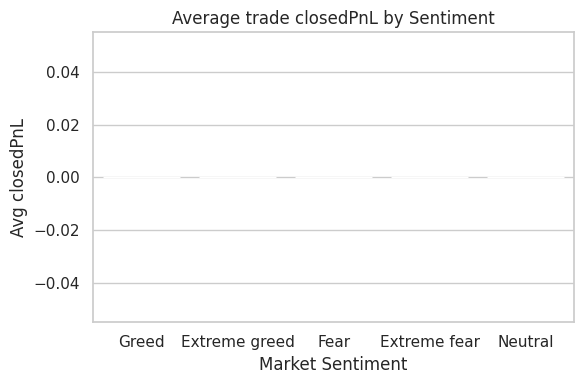

No leverage data available to create boxplot


<Figure size 800x500 with 0 Axes>

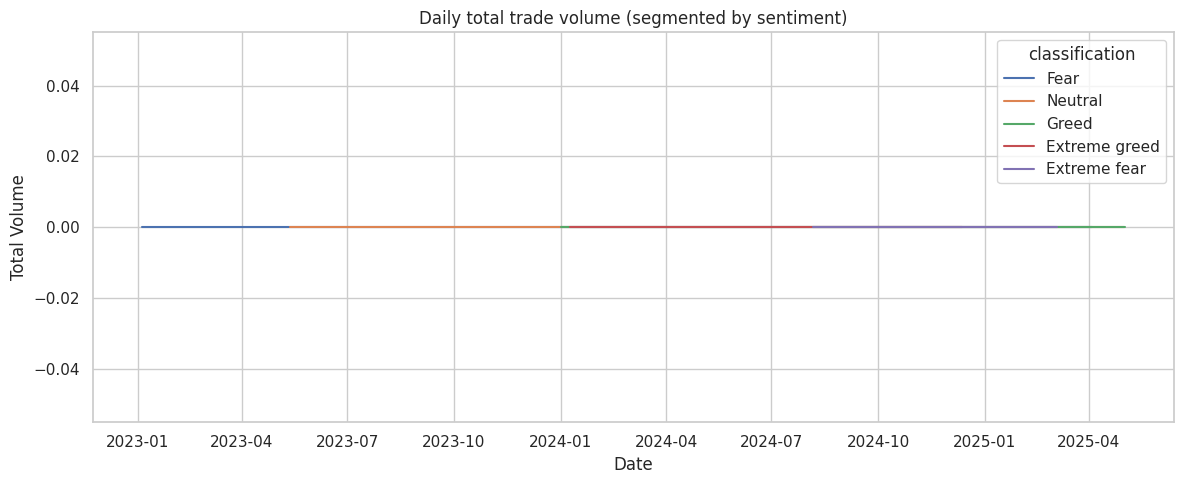

No valid numeric data to compute correlation heatmap


In [50]:
plt.figure(figsize=(6,4))
plot_df = df.dropna(subset=['classification', 'closedpnl'])
if not plot_df.empty:
    sns.barplot(data=plot_df, x='classification', y='closedpnl', estimator='mean')
    plt.title('Average trade closedPnL by Sentiment')
    plt.ylabel('Avg closedPnL')
    plt.xlabel('Market Sentiment')
    plt.tight_layout()
    plt.savefig(OUTPUTS_DIR / 'avg_pnl_by_sentiment.png')
    plt.show()
else:
    print('No data available to plot avg PnL by sentiment')

plt.figure(figsize=(8,5))
plot_df2 = df.dropna(subset=['classification', 'abs_leverage'])
if not plot_df2.empty and plot_df2['classification'].nunique() > 0:
    sns.boxplot(data=plot_df2, x='classification', y='abs_leverage')
    plt.title('Leverage distribution by Sentiment')
    plt.ylabel('Absolute leverage')
    plt.xlabel('Market Sentiment')
    plt.tight_layout()
    plt.savefig(OUTPUTS_DIR / 'leverage_boxplot_by_sentiment.png')
    plt.show()
else:
    print('No leverage data available to create boxplot')

plt.figure(figsize=(12,5))
if not daily.empty:
    daily['date_only'] = pd.to_datetime(daily['date_only'])
    sns.lineplot(data=daily, x='date_only', y='total_volume', hue='classification', estimator=None)
    plt.title('Daily total trade volume (segmented by sentiment)')
    plt.xlabel('Date')
    plt.ylabel('Total Volume')
    plt.tight_layout()
    plt.savefig(OUTPUTS_DIR / 'daily_volume_by_sentiment.png')
    plt.show()
else:
    print('No daily aggregate data to plot')

numcols = [c for c in ['trade_volume_abs', 'abs_leverage', 'closedpnl'] if c in df.columns]

if len(numcols) >= 2:
    df_num = df[numcols].apply(pd.to_numeric, errors='coerce').dropna(how='any')
    if not df_num.empty:
        corr = df_num.corr()
        plt.figure(figsize=(5, 4))
        sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
        plt.title('Correlation among volume, leverage, pnl')
        plt.tight_layout()
        plt.savefig(OUTPUTS_DIR / 'corr_heatmap.png')
        plt.show()
    else:
        print('No valid numeric data to compute correlation heatmap')
else:
    print('Not enough numeric columns available to compute correlation heatmap')



In [51]:
greed = df[df['classification'] == 'Greed']['closedpnl'].dropna()
fear = df[df['classification'] == 'Fear']['closedpnl'].dropna()

print('Greed samples:', len(greed), 'Fear samples:', len(fear))
if len(greed) > 3 and len(fear) > 3:
    t_stat, t_p = stats.ttest_ind(greed, fear, equal_var=False, nan_policy='omit')
    u_stat, u_p = stats.mannwhitneyu(greed, fear, alternative='two-sided')
    print('t-test p-value:', t_p)
    print('Mann-Whitney p-value:', u_p)
else:
    print('Not enough samples to perform robust statistical tests (need >3 in each group).')


Greed samples: 11292 Fear samples: 13869
t-test p-value: nan
Mann-Whitney p-value: 1.0


In [52]:
from fpdf import FPDF

imgs = [p.name for p in OUTPUTS_DIR.iterdir() if p.suffix.lower() in ('.png', '.jpg', '.jpeg')]
print('Images saved in outputs:', imgs)

pdf = FPDF()
pdf.set_auto_page_break(auto=True, margin=15)
pdf.add_page()
pdf.set_font('Arial', 'B', 14)
pdf.cell(0, 8, 'DS Report: Trader Behavior vs Market Sentiment', ln=True)
pdf.ln(4)
pdf.set_font('Arial', size=11)
pdf.multi_cell(0, 6, 'This report summarizes exploratory analysis investigating how trader behavior (PnL, leverage, volume) aligns with market sentiment (Fear vs Greed). Figures below were generated programmatically.')

for im in imgs:
    img_path = OUTPUTS_DIR / im
    try:
        pdf.add_page()
        pdf.image(str(img_path), x=15, y=30, w=180)
    except Exception as e:
        print('Could not add image', img_path, 'to PDF:', e)

report_path = ROOT / 'ds_report.pdf'
pdf.output(str(report_path))
print('Report saved to:', report_path)


Images saved in outputs: ['avg_pnl_by_sentiment.png', 'daily_volume_by_sentiment.png']
Report saved to: /content/ds_SADANALA_ASHRITHA/ds_report.pdf


In [53]:
readme = ROOT / 'README.md'
readme.write_text(f"""# ds_{CANDIDATE_NAME}

This submission contains analysis for the Web3 Trading Team assignment.

Structure:
- notebook_1.ipynb  (main analysis — paste/transfer this Colab into it)
- csv_files/        (original and processed CSVs)
- outputs/          (plots used in report)
- ds_report.pdf     (summary report)

Notes:
- Sentiment file used: fear_greed.csv
- Trader file used: hyperliquid_trader_data.csv
- Steps: cleaning -> merge by date -> feature engineering -> EDA -> statistical tests -> PDF report
""")
print('README created at', readme)


README created at /content/ds_SADANALA_ASHRITHA/README.md
